In [3]:
import numpy as np
from netCDF4 import Dataset
import glob
from metpy.units import units
from metpy.calc import moist_lapse

import math
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from metpy.calc import saturation_mixing_ratio
from wrf import interplevel,to_np
from skimage import data, filters, measure, morphology
import xarray as xr
from distributed import Client, performance_report

import sys
sys.path.insert(0, '/disk/v050.b/jchenfw/my_python/jianan_tools/')

In [4]:

from jianan_thermal import normalize_sensi
from jianan_rainfall import check_rainfall, regional_averege

In [5]:
zh=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics.nc')['zh_3d'][0,:,0])
y=np.arange(-200*256,200*256,200)/1000
X,Y = np.meshgrid(y,zh)

sfc_orignal   = 300.4898   
sfc_temp_30_40= 301.0013  
sfc_temp_50_60=  301.6691
sfc_temp_70_80 =  302.7475
sfc_temp_90_100 = 304.0202  
sfc_t_array= [ sfc_orignal,sfc_temp_30_40,sfc_temp_50_60,sfc_temp_70_80,sfc_temp_90_100 ]

simu_list_name=['base', '30_40', '50_60', '70_80', '90_100']
anoma_list_name=['30_base', '50_base', '70_base', '90_base']
label_array=['(a)' ,'(b)' ,'(c)' ,'(d)' ,'(e)'  ]
pic_path='/disk/v050.b/jchenfw/pictures/qt_contours/qsci/'

In [6]:
xs_cond_list_qci5=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/cond_xs_2dyz_qci5.nc')['cond_2d_m'])
xs_cond_list_qci6=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/cond_xs_2dyz_qci6.nc')['cond_2d_m'])

In [7]:
qs_2d_list= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qs_2d_list'])
qc_2d_list= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qc_2d_list'])
qi_2d_list= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qi_2d_list'])
qg_2d_list= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qg_2d_list'])
qr_2d_list= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qr_2d_list'])

qs_2d_list_w= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qs_2d_w_list'])
qc_2d_list_w= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qc_2d_w_list'])
qi_2d_list_w= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qi_2d_w_list'])
qg_2d_list_w= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted.nc')['qg_2d_w_list'])
qr_2d_list_w= np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qscigr/qscigr_weighted_test.nc')['qr_2d_w_list'])

qt_evac_2d_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_dep.nc')['evac_3d'])
qt_evar_2d_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_dep.nc')['evar_3d'])
qt_cond_2d_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_dep.nc')['cond_3d'])
qt_dep_2d_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_dep.nc')['dep_3d'])
qt_subl_2d_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_dep.nc')['subl_3d'])

qt_cond_2d_w_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_weighted.nc')['cond_3d_w'])
qt_evar_2d_w_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_weighted.nc')['evar_3d_w'])
qt_evac_2d_w_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_weighted.nc')['evac_3d_w'])
qt_subl_2d_w_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_weighted.nc')['subl_3d_w'])
qt_dep_2d_w_list=np.array(xr.open_dataset('/disk/v050.b/jchenfw/contribution_nc/qt_qvb_data/qt_statistics_weighted.nc')['dep_3d_w'])

In [8]:
def get_pe_2d(qt_cond_2d_w_list,  qt_dep_2d_w_list,  qt_evar_2d_w_list, qt_evac_2d_w_list ,qt_subl_2d_w_list,zh, y_start, y_end, slope=-0.001):
    

    y_start_array= slope*zh  +y_start
    y_end_array= slope*zh  +y_end

    y_start_ind=    int(y_start/0.200)+256 
    y_end_ind=      int(y_end/0.200)+256 

    y_start_ind_array=  256+ (y_start_array/0.200).astype('int')
    y_end_ind_array=    256+ (y_end_array/0.200).astype('int')   

    ny= y_end_ind -y_start_ind

    nz= len(zh)
    
    qt_cond_rec= np.zeros(shape=(nz,ny)) # the ny point number 
    qt_evar_rec= np.zeros(shape=(nz,ny))
    qt_evac_rec= np.zeros(shape=(nz,ny))
    qt_subl_rec= np.zeros(shape=(nz,ny))
    qt_dep_rec = np.zeros(shape=(nz,ny))

    for  k in np.arange(nz):
        
        y_index_array_lvl= np.arange(y_start_ind_array[k],y_end_ind_array[k],1)

        for jid,j in enumerate(y_index_array_lvl) :
            #print(k, jid,j)
            qt_cond_rec[k,jid]  = qt_cond_2d_w_list[k, j]
            qt_subl_rec[k,jid]  = qt_subl_2d_w_list[k, j]
            qt_evar_rec[k,jid]  = qt_evar_2d_w_list[k, j]
            qt_evac_rec[k,jid]  = qt_evac_2d_w_list[k, j]
            qt_dep_rec[k,jid]   = qt_dep_2d_w_list[k, j]

    ratio= np.nansum(qt_subl_rec+qt_evar_rec+qt_evac_rec)/ np.nansum(-qt_cond_rec-qt_dep_rec)
    pe= 1-ratio

    fig=plt.figure(figsize=[20,8])

    ax1=fig.add_subplot(1,1,1)
    
    for sid, ax in enumerate([ax1]):

        ax_1=ax.contourf(X,Y, -qt_cond_2d_w_list-qt_dep_2d_w_list,40,cmap='jet')
        fig.colorbar(ax_1,ax=ax)
        ax.set_ylim(0,20000)
        ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
        ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
        ax.set_title('qs in warming: ' + simu_list_name[sid], fontsize=20)
        ax.set_ylabel('Z (m)',fontsize=18)
        ax.plot( y_start_array  ,zh,'k--')
        ax.plot(  y_end_array ,zh, 'k--')

    plt.tight_layout()
    return pe

In [9]:


def get_pe_3d(qt_cond_2d_w_list,  qt_dep_2d_w_list,  qt_evar_2d_w_list, qt_evac_2d_w_list ,qt_subl_2d_w_list,zh, y_start, y_end, slope=-0.001):


    
    rain_rate_3d,zs,y_,rain_rate=check_rainfall(start_time=6, end_time=31, simu_group=['first','second','third','fourth','fifth'],
    simu_list= [ 'base/', '30_40/' , '50_60/' ,  '70_80/', '90_100/'],fir_dir_group='/disk/v050.b/jchenfw/rainfall_data/base_width/')
    rain_rate_2d= rain_rate_3d[:,1,:]
    r_y_start=  int(y_start/0.200)+256 
    r_y_end=    int(y_end/0.200)+256 
    rain_rate_1d= np.nanmean(rain_rate_2d[r_y_start:r_y_end,:],axis=0)
    
    print(' the sensitivity is of rain rate ')
    print(normalize_sensi(rain_rate_1d,sfc_t_array) *100 )

    simu_list_name = ['base', '30','50','70', '90']
    pe_array=np.zeros(shape=len(simu_list_name))

    real_pe_array= np.zeros(shape=len(simu_list_name))
    for sid in np.arange(len(simu_list_name)):

        y_start_array= slope*zh  +y_start
        y_end_array= slope*zh  +y_end

        y_start_ind=    int(y_start/0.200)+256 
        y_end_ind=      int(y_end/0.200)+256 

        y_start_ind_array=  256+ (y_start_array/0.200).astype('int')
        y_end_ind_array=    256+ (y_end_array/0.200).astype('int')   

        ny= y_end_ind -y_start_ind

        nz= len(zh)
        
        qt_cond_rec= np.zeros(shape=(nz,ny)) # the ny point number 
        qt_evar_rec= np.zeros(shape=(nz,ny))
        qt_evac_rec= np.zeros(shape=(nz,ny))
        qt_subl_rec= np.zeros(shape=(nz,ny))
        qt_dep_rec = np.zeros(shape=(nz,ny))

        for  k in np.arange(nz):
            
            y_index_array_lvl= np.arange(y_start_ind_array[k],y_end_ind_array[k],1)

            for jid,j in enumerate(y_index_array_lvl) :
                #print(k, jid,j)
                qt_cond_rec[k,jid]  = qt_cond_2d_w_list[sid,k, j]
                qt_subl_rec[k,jid]  = qt_subl_2d_w_list[sid,k, j]
                qt_evar_rec[k,jid]  = qt_evar_2d_w_list[sid,k, j]
                qt_evac_rec[k,jid]  = qt_evac_2d_w_list[sid,k, j]
                qt_dep_rec[k,jid]   = qt_dep_2d_w_list[sid, k, j]

        ratio= np.nansum(qt_subl_rec+qt_evar_rec+qt_evac_rec)/ np.nansum(-qt_cond_rec-qt_dep_rec)
        pe= 1-ratio
        pe_array[sid]= pe
        real_pe_array[sid]=rain_rate_1d[sid]/ (np.nansum(-qt_cond_rec-qt_dep_rec)*3600/(ny)) 
        
    print('not real pe') 
    print(pe_array)
    print(' the sensitivity is of not real pe ')
    print(normalize_sensi(pe_array,sfc_t_array) *100 )

    print(' real pe') 
    print(real_pe_array)
    print(' the sensitivity is of real pe ')
    print(normalize_sensi(real_pe_array,sfc_t_array) *100 )

    fig=plt.figure(figsize=[25,25])

    ax1=fig.add_subplot(5,1,1)
    ax2=fig.add_subplot(5,1,2)
    ax3=fig.add_subplot(5,1,3)
    ax4=fig.add_subplot(5,1,4)
    ax5=fig.add_subplot(5,1,5)
    
    for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

        ax_1=ax.contourf(X,Y, -qt_cond_2d_w_list[sid,:,:]-qt_dep_2d_w_list[sid,:,:],40,cmap='jet')
        fig.colorbar(ax_1,ax=ax)
        ax.set_ylim(0,20000)
        ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
        ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
        ax.set_title('qs in warming: ' + simu_list_name[sid], fontsize=20)
        ax.set_ylabel('Z (m)',fontsize=18)
        ax.plot( y_start_array  ,zh,'k--')
        ax.plot(  y_end_array ,zh, 'k--')
        ax.set_xlim(-51.2,51.2)

    plt.tight_layout()
    return pe_array


In [10]:
file_1= '/disk/v050.b/jchenfw/contribution_nc/output/qci5_w1/whole_domain/warm_30.nc'
file_2= '/disk/v050.b/jchenfw/contribution_nc/output/qci5_w1/whole_domain/warm_50.nc'
file_3= '/disk/v050.b/jchenfw/contribution_nc/output/qci5_w1/whole_domain/warm_70.nc'
file_4= '/disk/v050.b/jchenfw/contribution_nc/output/qci5_w1/whole_domain/warm_90.nc'


warm_30=xr.open_dataset(file_1)
warm_50=xr.open_dataset(file_2)
warm_70=xr.open_dataset(file_3)
warm_90=xr.open_dataset(file_4)

ther_3d_30 , dyna_3d_30, area_3d_30, cond_3d_30, cond_3d_base\
    = warm_30['ther_3d_30'] ,warm_30['dyna_3d_30'], warm_30['area_3d_30'],warm_30['cond_f_3d_30'], warm_30['cond_c_3d']

ther_3d_50 , dyna_3d_50, area_3d_50, cond_3d_50,\
    = warm_50['ther_3d_50'] ,warm_50['dyna_3d_50'], warm_50['area_3d_50'],warm_50['cond_f_3d_50']

ther_3d_70, dyna_3d_70,  area_3d_70, cond_3d_70 \
    =warm_70['ther_3d_70'], warm_70['dyna_3d_70'], warm_70['area_3d_70'], warm_70['cond_f_3d_70']

ther_3d_90, dyna_3d_90,  area_3d_90, cond_3d_90 \
    =warm_90['ther_3d_90'], warm_90['dyna_3d_90'], warm_90['area_3d_90'], warm_90['cond_f_3d_90']

In [11]:
ther_2d= np.array([np.nanmean(  ther_3d_30,axis=(1,2)), np.nanmean(  ther_3d_50,axis=(1,2)), np.nanmean(  ther_3d_70,axis=(1,2)),np.nanmean(  ther_3d_90,axis=(1,2)) ])
area_2d= np.array([np.nanmean(  area_3d_30,axis=(1,2)), np.nanmean(  area_3d_50,axis=(1,2)), np.nanmean(  area_3d_70,axis=(1,2)),np.nanmean(  area_3d_90,axis=(1,2)) ])
dyna_2d= np.array([np.nanmean(  dyna_3d_30,axis=(1,2)), np.nanmean(  dyna_3d_50,axis=(1,2)), np.nanmean(  dyna_3d_70,axis=(1,2)),np.nanmean(  dyna_3d_90,axis=(1,2)) ])
cond_2d= np.array([np.nanmean(  cond_3d_base,axis=(1,2)), np.nanmean(  cond_3d_30,axis=(1,2)), np.nanmean(  cond_3d_50,axis=(1,2)), np.nanmean(  cond_3d_70,axis=(1,2)),np.nanmean(  cond_3d_90,axis=(1,2)) ])

In [12]:
cond_2d.shape

(5, 512)

In [70]:
def get_pe_3d_2(xs_cond_list_qci5,zh, y_start, y_end, ther_2d,area_2d,  dyna_2d, cond_2d, slope=-0.001):
    
    rain_rate_3d,zs,y_,rain_rate=check_rainfall(start_time=6, end_time=31, simu_group=['first','second','third','fourth','fifth'],
    simu_list= [ 'base/', '30_40/' , '50_60/' ,  '70_80/', '90_100/'],fir_dir_group='/disk/v050.b/jchenfw/rainfall_data/base_width/')
    rain_rate_2d= rain_rate_3d[:,1,:]
    r_y_start=  int(y_start/0.200)+256 
    r_y_end=    int(y_end/0.200)+256 
    rain_rate_1d= np.nanmean(rain_rate_2d[r_y_start:r_y_end,:],axis=0)

    print(' the sensitivity of rain rate is ')
    print(normalize_sensi(rain_rate_1d,sfc_t_array) *100 )
    simu_list_name = ['base', '30','50','70', '90']

    y_start_array= slope*zh  +y_start
    y_end_array= slope*zh  +y_end
    y_start_ind=    int(y_start/0.200)+256 
    y_end_ind=      int(y_end/0.200)+256 
    y_start_ind_array=  256+ (y_start_array/0.200).astype('int')
    y_end_ind_array=    256+ (y_end_array/0.200).astype('int')   

    ny= y_end_ind -y_start_ind
    nz= len(zh)
    xs_cond_rec_3d= np.zeros(shape=(5,nz,ny)) # the ny point number 
    

    real_pe_array= np.zeros(shape=len(simu_list_name))

    for sid in np.arange(len(simu_list_name)):

        for  k in np.arange(nz):
            
            y_index_array_lvl= np.arange(y_start_ind_array[k],y_end_ind_array[k],1)

            for jid,j in enumerate(y_index_array_lvl) :

                xs_cond_rec_3d[sid,k,jid ]=xs_cond_list_qci5[k,j,sid]
   
    xs_cond_1d_rec= np.nansum( xs_cond_rec_3d, axis=(1,2))*3600/(ny)
    
    real_pe_array=rain_rate_1d/ (xs_cond_1d_rec) 


    fig=plt.figure(figsize=[25,25])

    ax1=fig.add_subplot(5,2,1)
    ax2=fig.add_subplot(5,2,3)
    ax3=fig.add_subplot(5,2,5)
    ax4=fig.add_subplot(5,2,7)
    ax5=fig.add_subplot(5,2,9)

    ax6=fig.add_subplot(5,2,2)
    ax7=fig.add_subplot(5,2,4)
    ax8=fig.add_subplot(5,2,6)
    ax9=fig.add_subplot(5,2,8)
    ax10=fig.add_subplot(5,2,10)


    for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

        X,Y  =np.meshgrid(np.arange(-200*256,200*256,200)/1000,zh)
        ax_1=ax.contourf(X,Y, xs_cond_list_qci5[:,:,sid],40,cmap='jet')

        fig.colorbar(ax_1,ax=ax)
        ax.set_ylim(0,20000)
        ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
        ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
        ax.set_title('Condesation rate weighted by sk in warming: ' + simu_list_name[sid], fontsize=20)
        ax.set_ylabel('Z (m)',fontsize=18)
        ax.plot( y_start_array  ,zh,'k--')
        ax.plot(  y_end_array ,zh, 'k--')
        ax.set_xlim(-51.2,51.2)




    dyna_contri_list= np.nanmean( dyna_2d[:,y_start_ind:y_end_ind],axis=1) 
    area_contri_list= np.nanmean( area_2d[:,y_start_ind:y_end_ind],axis=1)
    ther_contri_list= np.nanmean( ther_2d[:,y_start_ind:y_end_ind],axis=1)
    cond_1d_list  = np.nanmean( cond_2d[:,y_start_ind:y_end_ind],axis=1)
    

    y=np.arange(-200*256,200*256,200)/1000
    for sid, ax in enumerate([ax6,ax7,ax8,ax9]):


        ax.plot(y , ther_2d[sid,:] ,label='ther')
        ax.plot(y , ther_2d[sid,:]+ dyna_2d[sid,:],'--k',label='ther+ dyna')
        ax.plot(y ,  ther_2d[sid,:]+ dyna_2d[sid,:]+area_2d[sid,:],'-r',label='ther+ dyna+ area')

        cond_diff = cond_2d[sid+1,:]-cond_2d[0,:]
        ax.plot(y , cond_diff ,'-k',label='real cond diff')
        
        ax.legend()
        #ax.plot(np.arange(-200*256,200*256,200)/1000,  np.nansum( xs_cond_list_qci5*3600, axis=(0) )[:,sid] )
        #ax.plot(np.arange(-200*256,200*256,200)/1000, cond_2d[sid,:])
        ax.vlines(x= y_end, ymin=-2, ymax= 10, color='g',ls=':',lw=2)
        ax.vlines(x= y_start, ymin=-2, ymax=10, color='g',ls=':',lw=2)




        ax.text(0.08, 0.96,  'ther ' +"{:.2f}".format(ther_contri_list[sid]), transform=ax.transAxes, fontsize=12, va='top', ha='left')
        ax.text(0.08, 0.92,  'dyna ' +"{:.2f}".format(dyna_contri_list[sid]), transform=ax.transAxes, fontsize=12, va='top', ha='left')
        ax.text(0.08, 0.88,  'area ' +"{:.2f}".format(area_contri_list[sid]), transform=ax.transAxes, fontsize=12, va='top', ha='left')
        ax.text(0.08, 0.84,  'cond_diff ' +"{:.2f}".format( cond_1d_list[sid+1]-cond_1d_list[0]), transform=ax.transAxes, fontsize=12, va='top', ha='left')
        
        ax.text(0.38, 0.96,  'ther ' +"{:.2f}".format(ther_contri_list[sid]/(cond_1d_list[sid+1]-cond_1d_list[0]) *100) + '%', 
        transform=ax.transAxes, fontsize=12, va='top', ha='left')
        ax.text(0.38, 0.92,  'dyna ' +"{:.2f}".format(dyna_contri_list[sid]/(cond_1d_list[sid+1]-cond_1d_list[0]) *100) + '%', 
        transform=ax.transAxes, fontsize=12, va='top', ha='left')
        ax.text(0.38, 0.88,  'area ' +"{:.2f}".format(area_contri_list[sid]/(cond_1d_list[sid+1]-cond_1d_list[0]) *100) + '%',
        transform=ax.transAxes, fontsize=12, va='top', ha='left')




    rain_change_1d_array_4= np.zeros(shape=4)
    cond_change_1d_array_4= np.zeros(shape=4)
    peff_change_1d_array_4= np.zeros(shape=4)

    

    for i in np.arange(4):
        rain_change_1d_array_4[i]=(rain_rate_1d[i+1]-rain_rate_1d[0])/ (rain_rate_1d[0] + rain_rate_1d[i+1])/2
        cond_change_1d_array_4[i]=(xs_cond_1d_rec[i+1]-xs_cond_1d_rec[0])/ (xs_cond_1d_rec[0]+xs_cond_1d_rec[i+1])/2
        peff_change_1d_array_4[i]=(real_pe_array[i+1]-real_pe_array[0])/ (real_pe_array[0] + real_pe_array[i+1])/2

    peff_contri_1d= peff_change_1d_array_4/rain_change_1d_array_4 *100
    cond_contri_1d= cond_change_1d_array_4/rain_change_1d_array_4 *100

    width=0.75
    bin_width=width/3
    ind=np.arange(5)

    ax10.bar(np.arange(4)-bin_width*1,peff_contri_1d ,width=bin_width,label='PE contribution')
    ax10.bar(np.arange(4)+bin_width*0,  cond_contri_1d,width=bin_width,label='condensation contribution')

    ax10.legend()

    for a,b,c in zip(np.arange(4), peff_contri_1d ,cond_contri_1d):

        ax10.text(a-bin_width*1, b+ b*0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=15)
        ax10.text(a-bin_width*0, c+ c*0.01, '%.2f' % c, ha='center', va= 'bottom',fontsize=15)


    plt.tight_layout()



 the sensitivity of rain rate is 
[13.96163623 17.2502862  14.61692471 13.6257388 ]


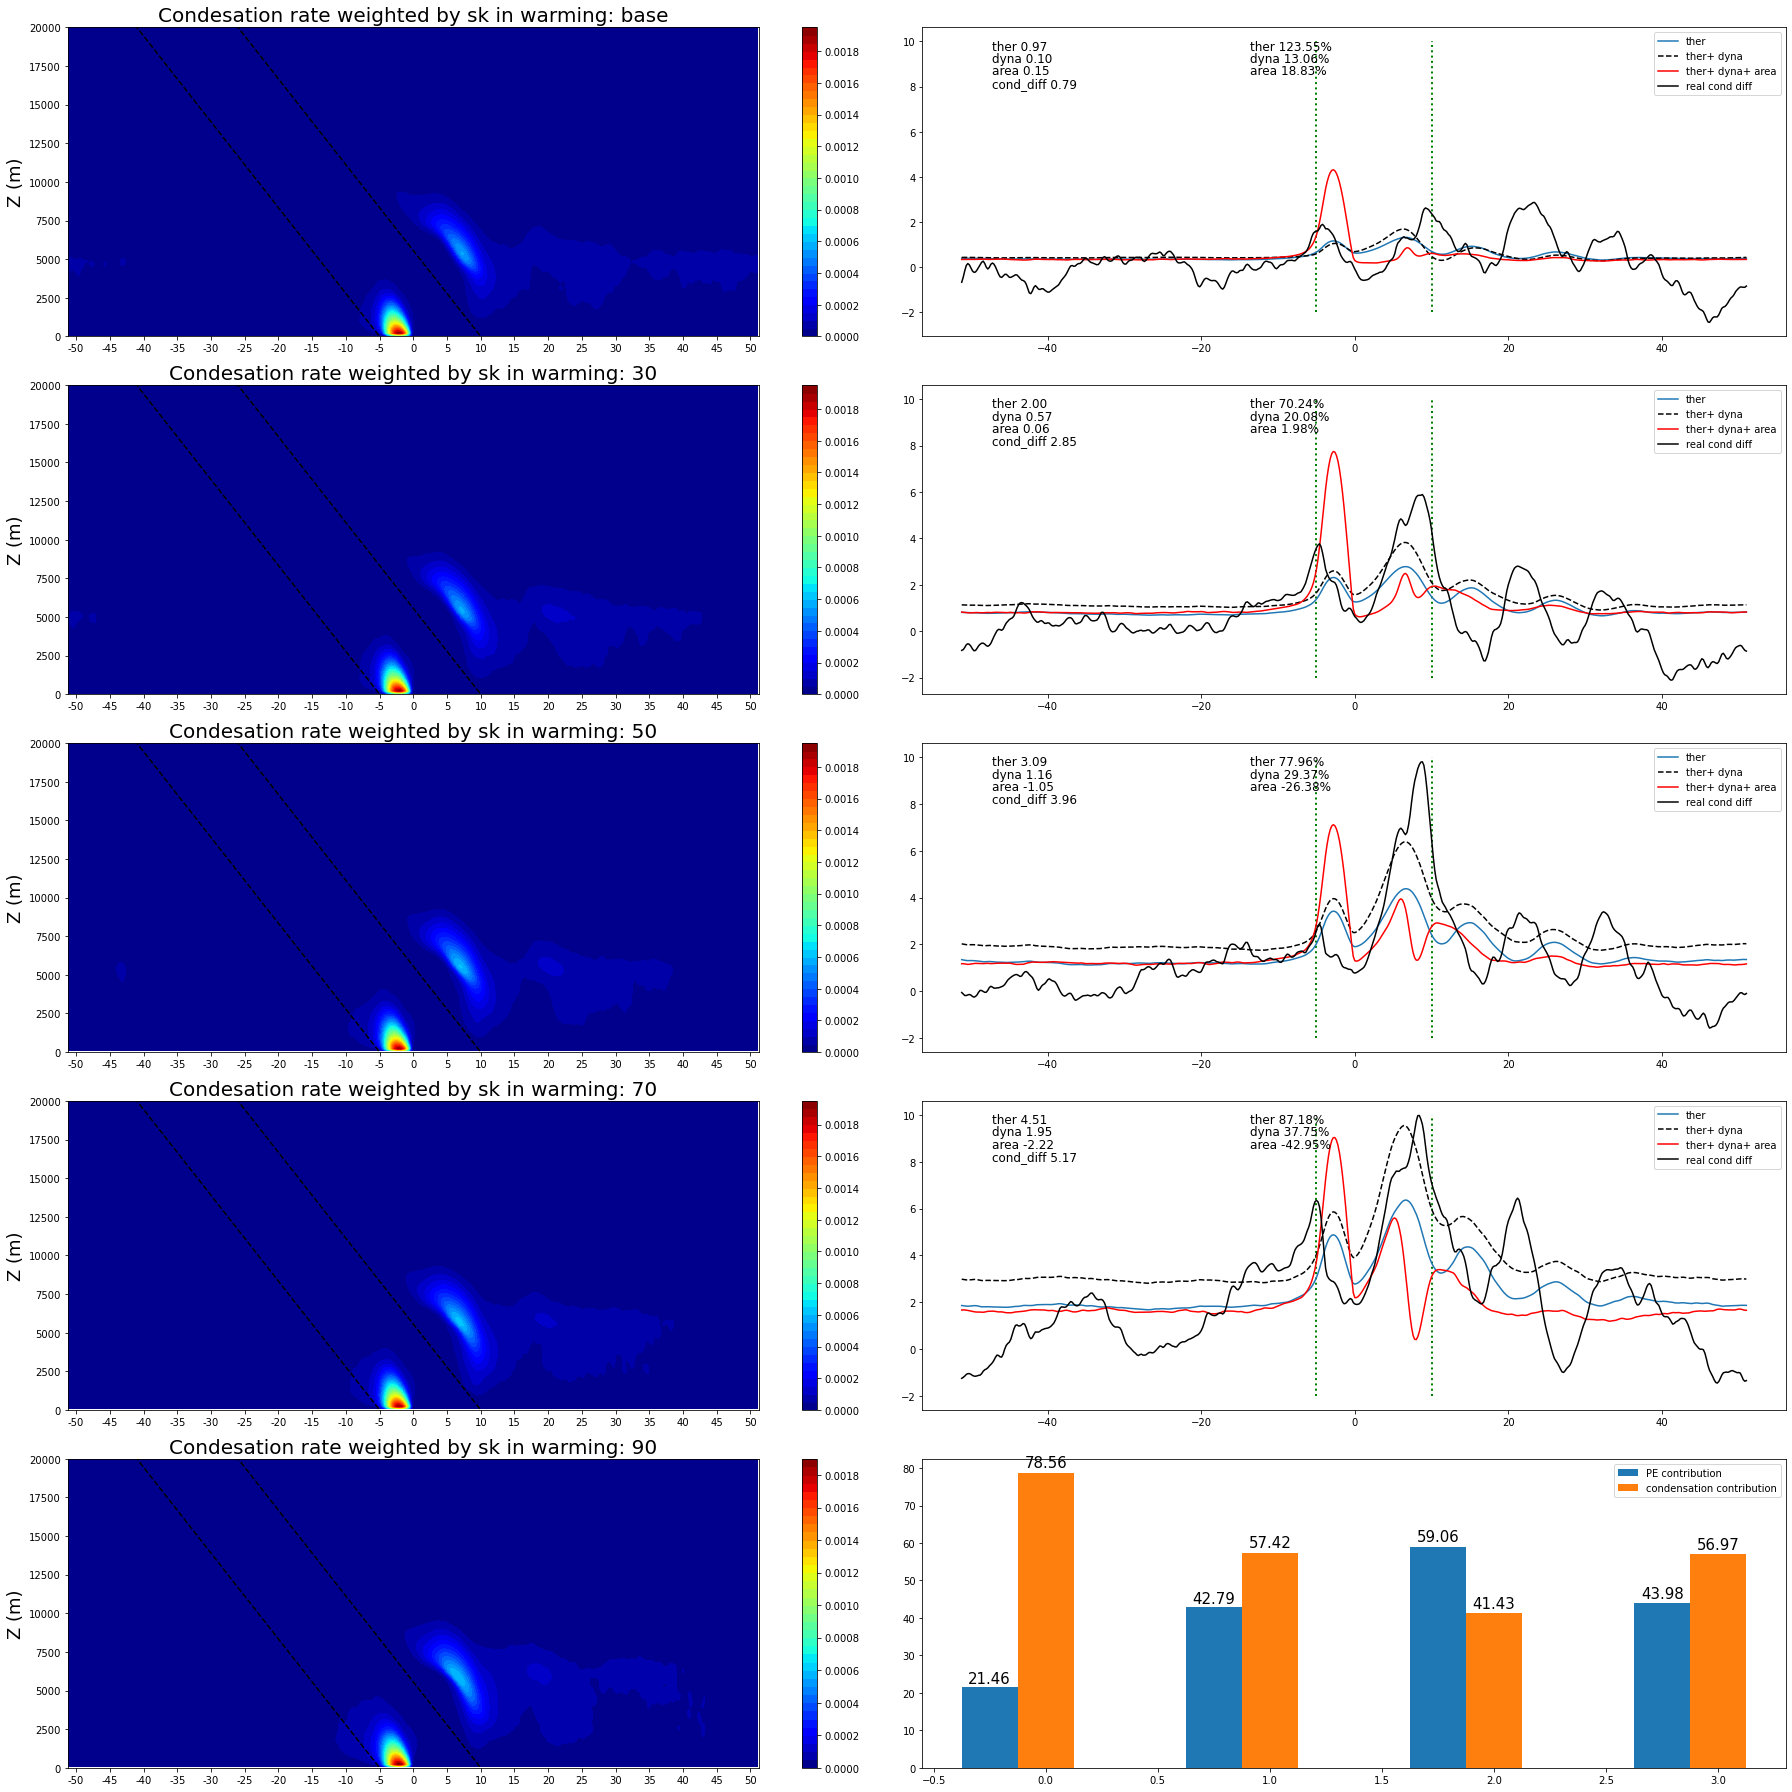

In [71]:
get_pe_3d_2(xs_cond_list_qci5,zh, -5, 10, ther_2d,area_2d,  dyna_2d, cond_2d, slope=-0.0018)

 the sensitivity of rain rate is 
[20.05480142 18.98203421 18.36757835 16.67163845]


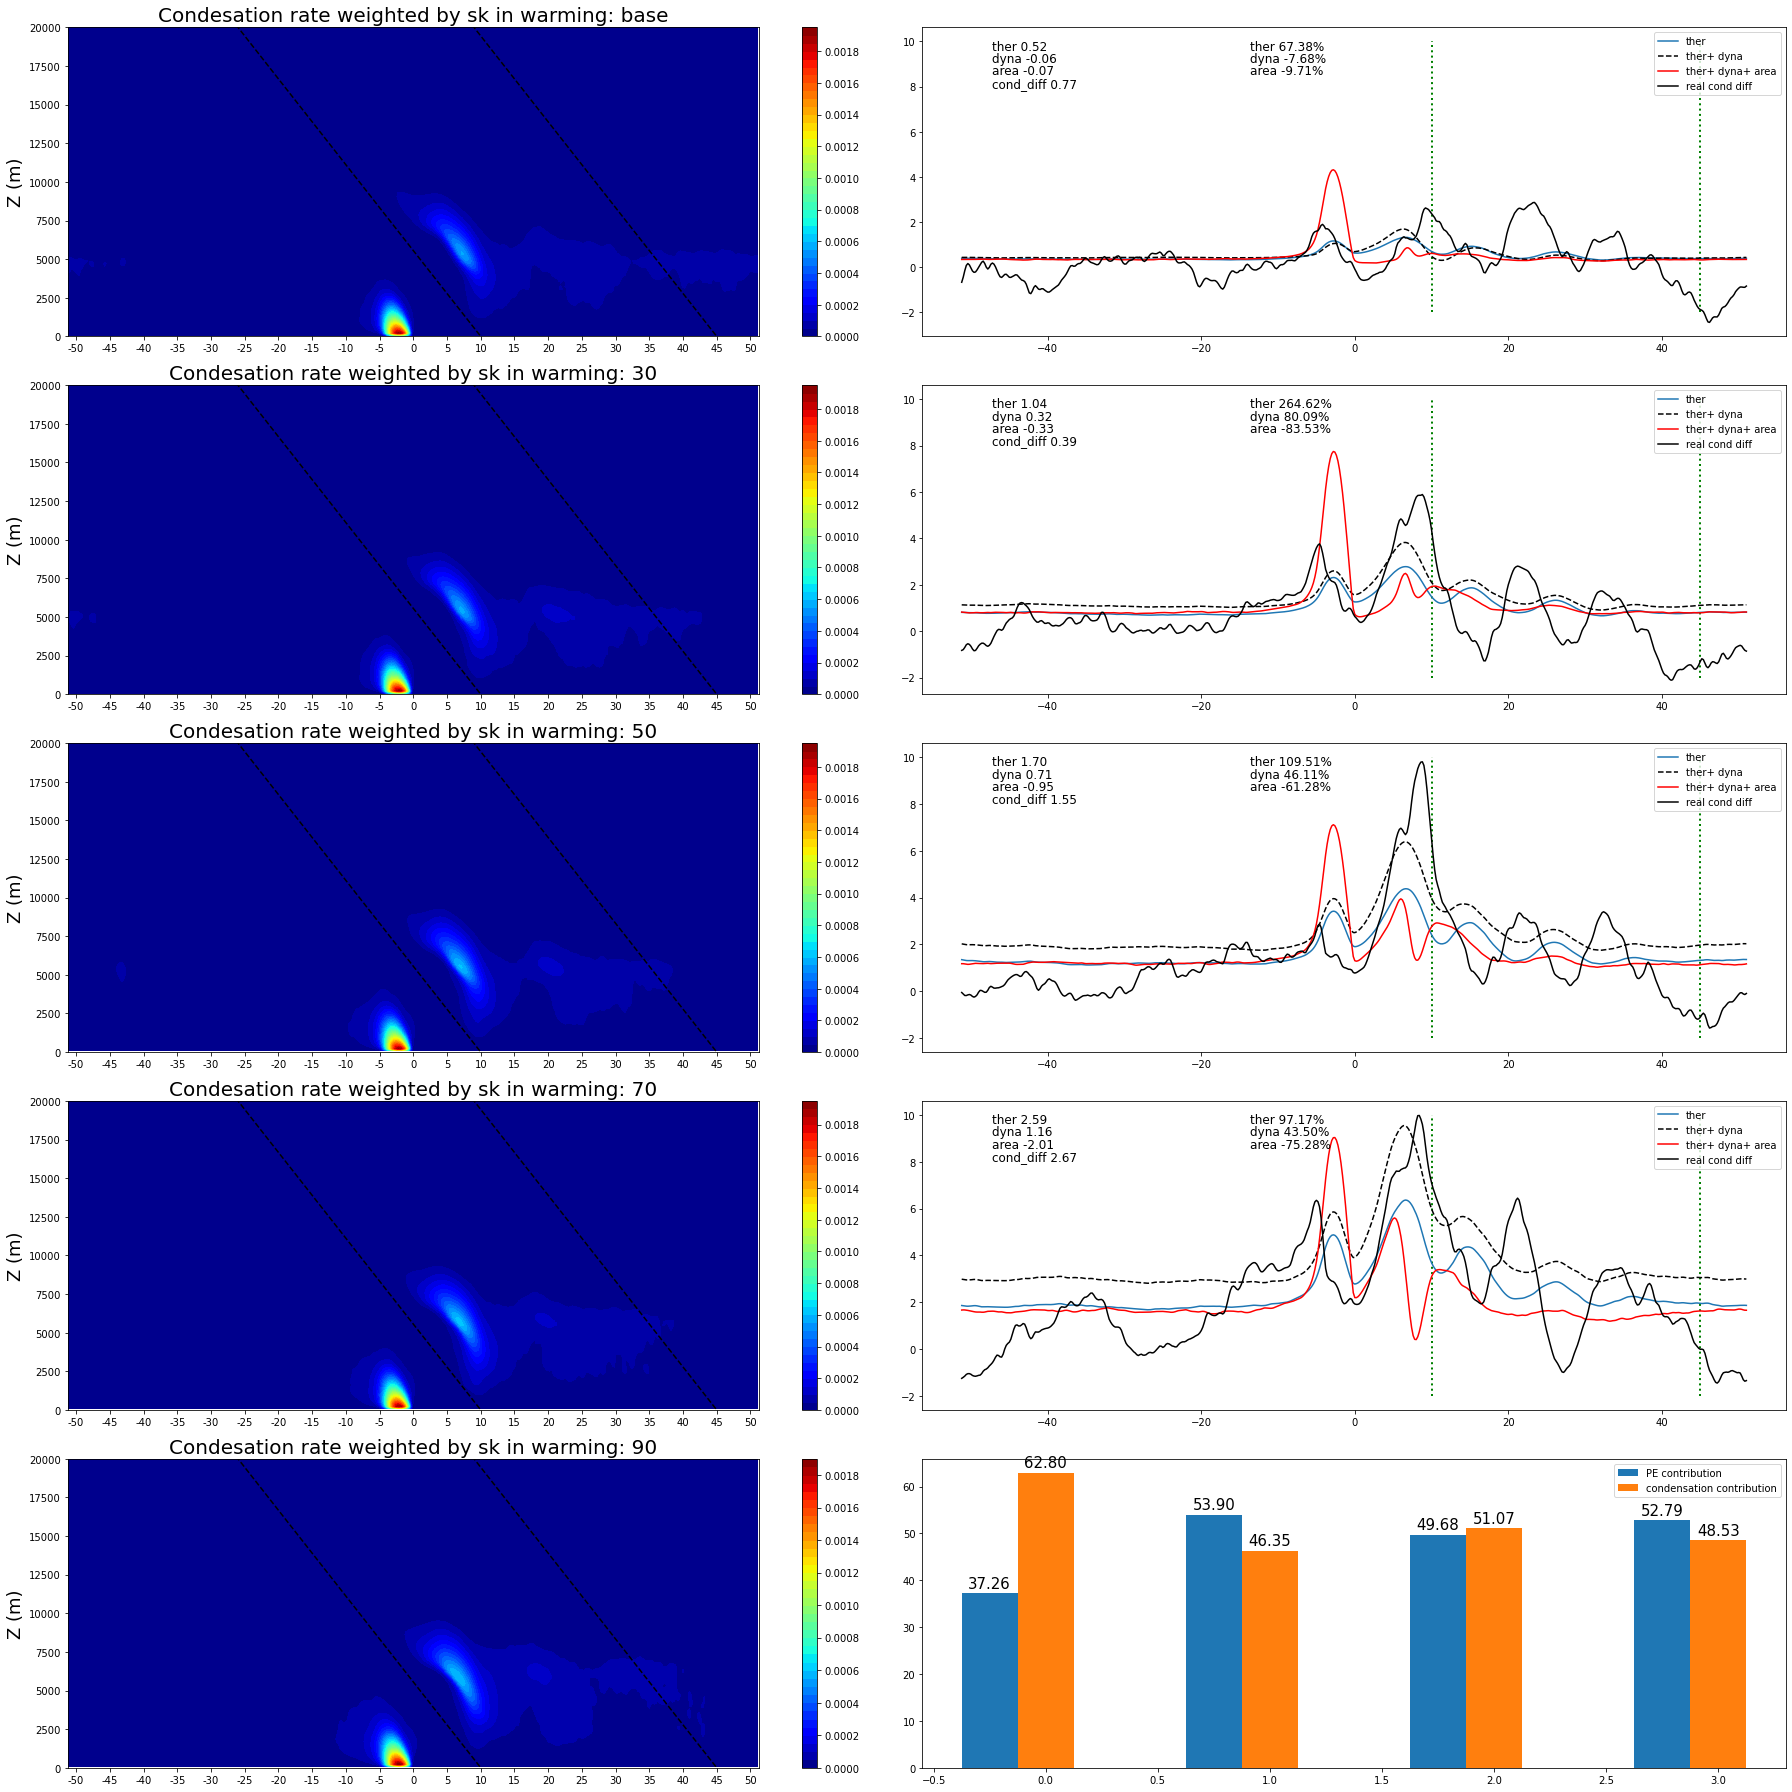

In [73]:
get_pe_3d_2(xs_cond_list_qci5,zh, 10, 45, ther_2d,area_2d,  dyna_2d, cond_2d, slope=-0.0018)

 the sensitivity of rain rate is 
[15.78597666 16.10085001 14.88727742 13.48295643]


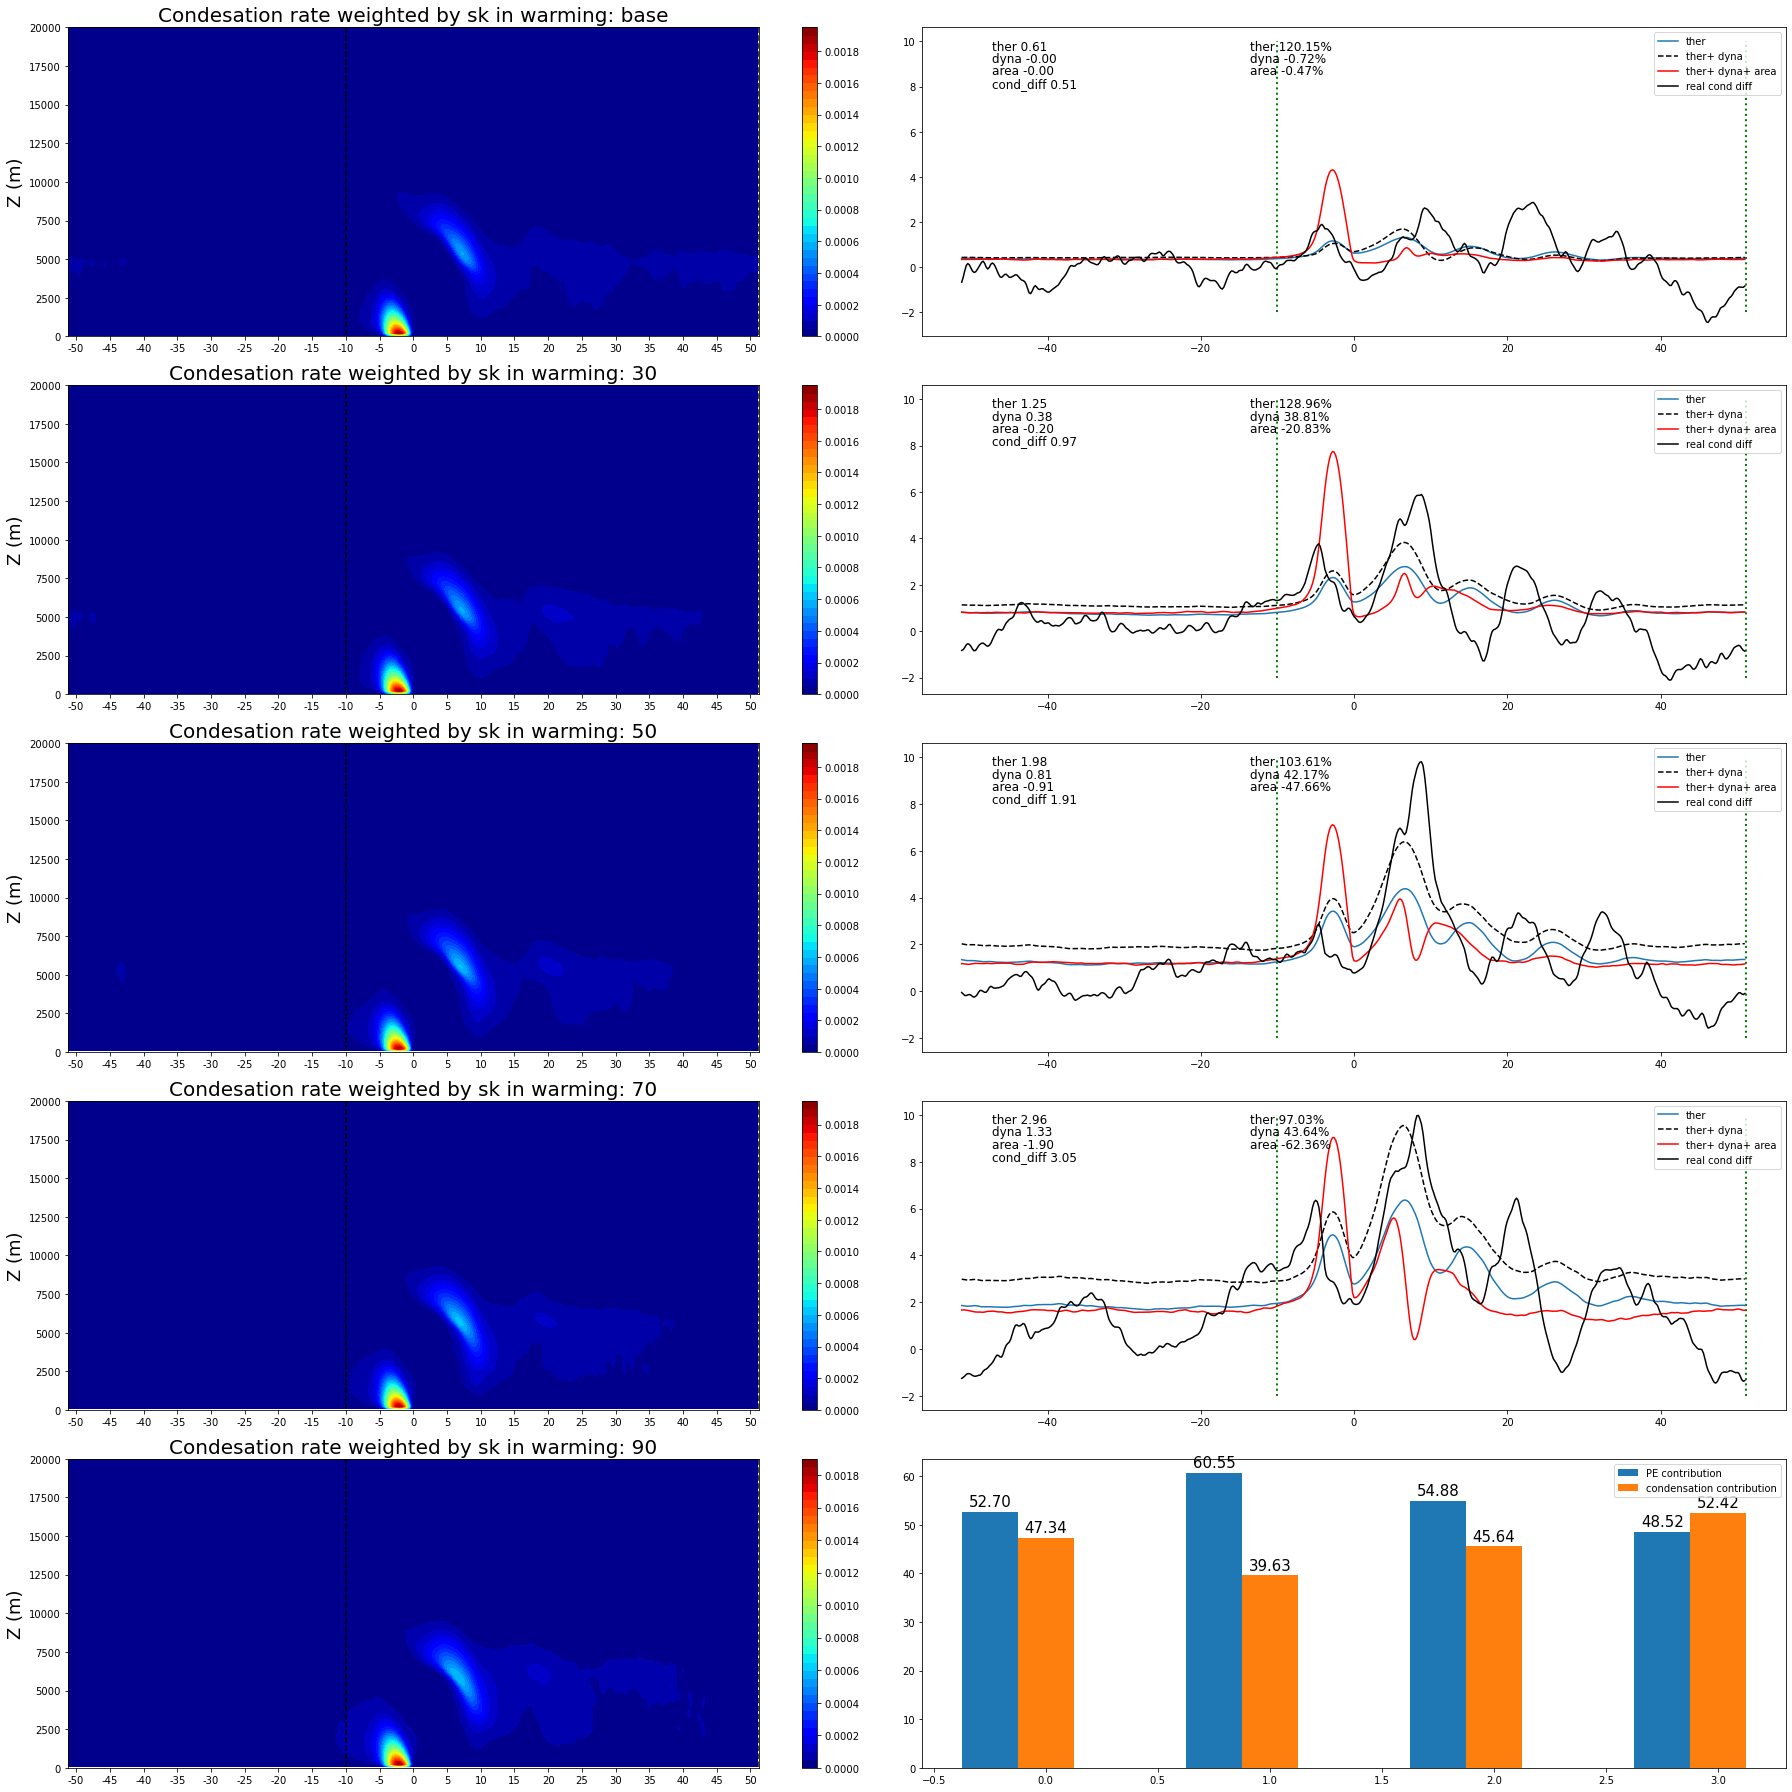

In [74]:
get_pe_3d_2(xs_cond_list_qci5,zh, -10, 51.2, ther_2d,area_2d,  dyna_2d, cond_2d, slope=-0.00)

 the sensitivity is of rain rate 
[13.96163623 17.2502862  14.61692471 13.6257388 ]
not real pe
[0.19704016 0.21608193 0.24662398 0.25369117 0.31601247]
 the sensitivity is of not real pe 
[18.89326262 21.3383565  12.73464075 17.10280145]
 real pe
[0.26459796 0.2678494  0.28531203 0.30938547 0.30474081]
 the sensitivity is of real pe 
[2.40238732 6.63826693 7.49728724 4.2973213 ]


array([0.19704016, 0.21608193, 0.24662398, 0.25369117, 0.31601247])

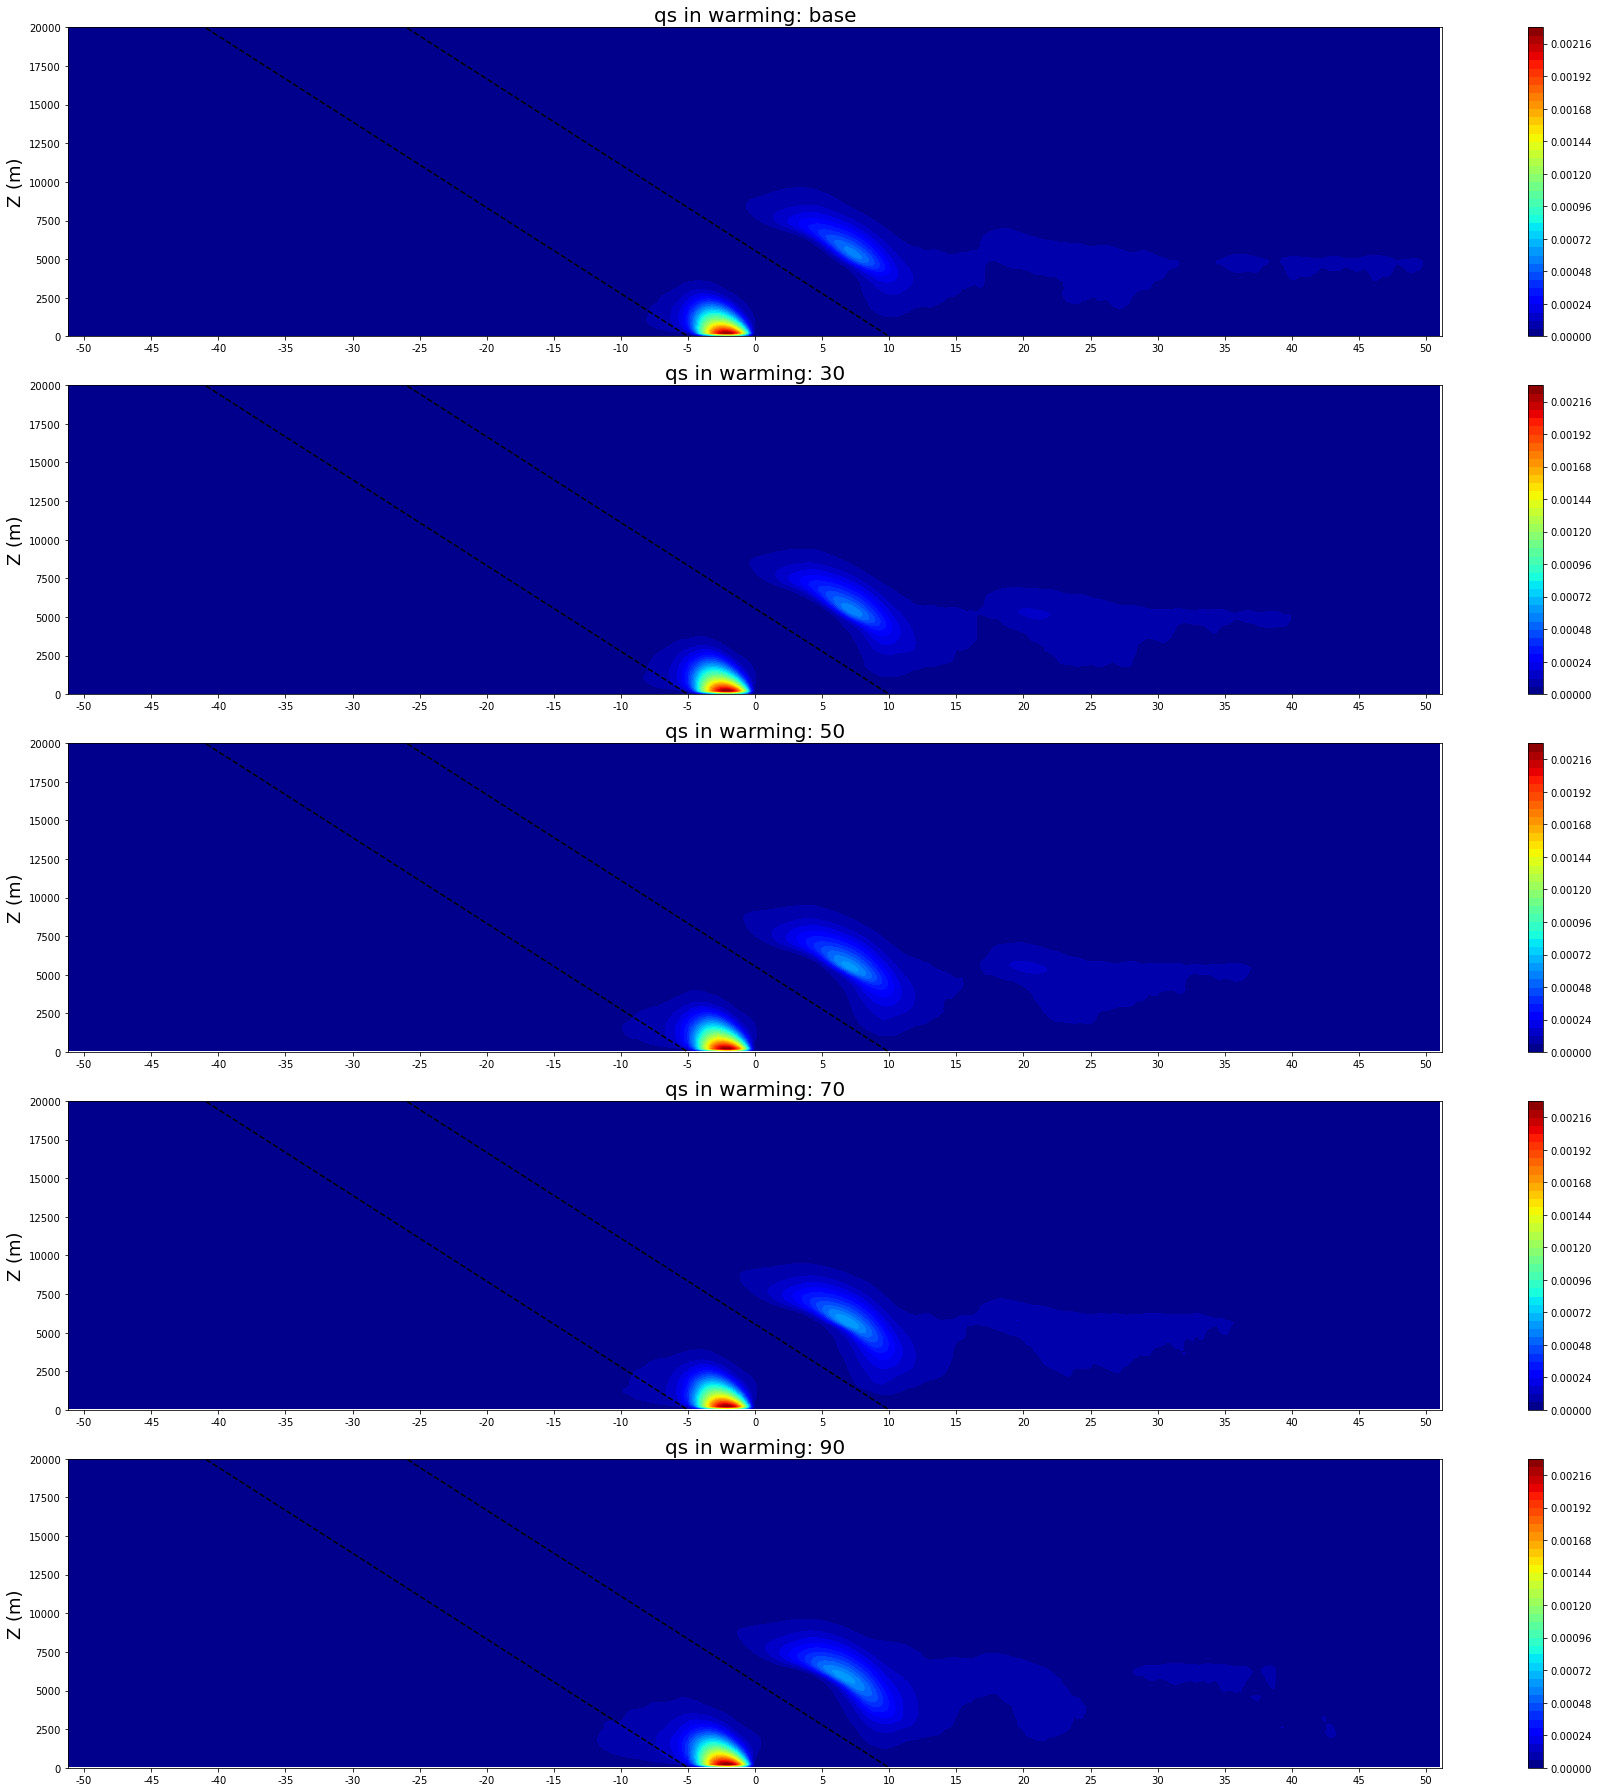

In [42]:
get_pe_3d( qt_cond_2d_w_list,qt_dep_2d_w_list,  qt_evar_2d_w_list, qt_evac_2d_w_list ,qt_subl_2d_w_list, zh, y_start=-5, slope=-0.0018, y_end=10)

 the sensitivity is of rain rate 
[18.22984004 16.82554965 16.08654478 14.32998782]
not real pe
[0.41635167 0.43176651 0.40821447 0.41184243 0.42167092]
 the sensitivity is of not real pe 
[ 7.23823923 -1.65725967 -0.47970806  0.36188092]
 real pe
[0.30164184 0.3102907  0.33470358 0.35246286 0.364908  ]
 the sensitivity is of real pe 
[5.60559638 9.29415367 7.46252064 5.94095092]


array([0.41635167, 0.43176651, 0.40821447, 0.41184243, 0.42167092])

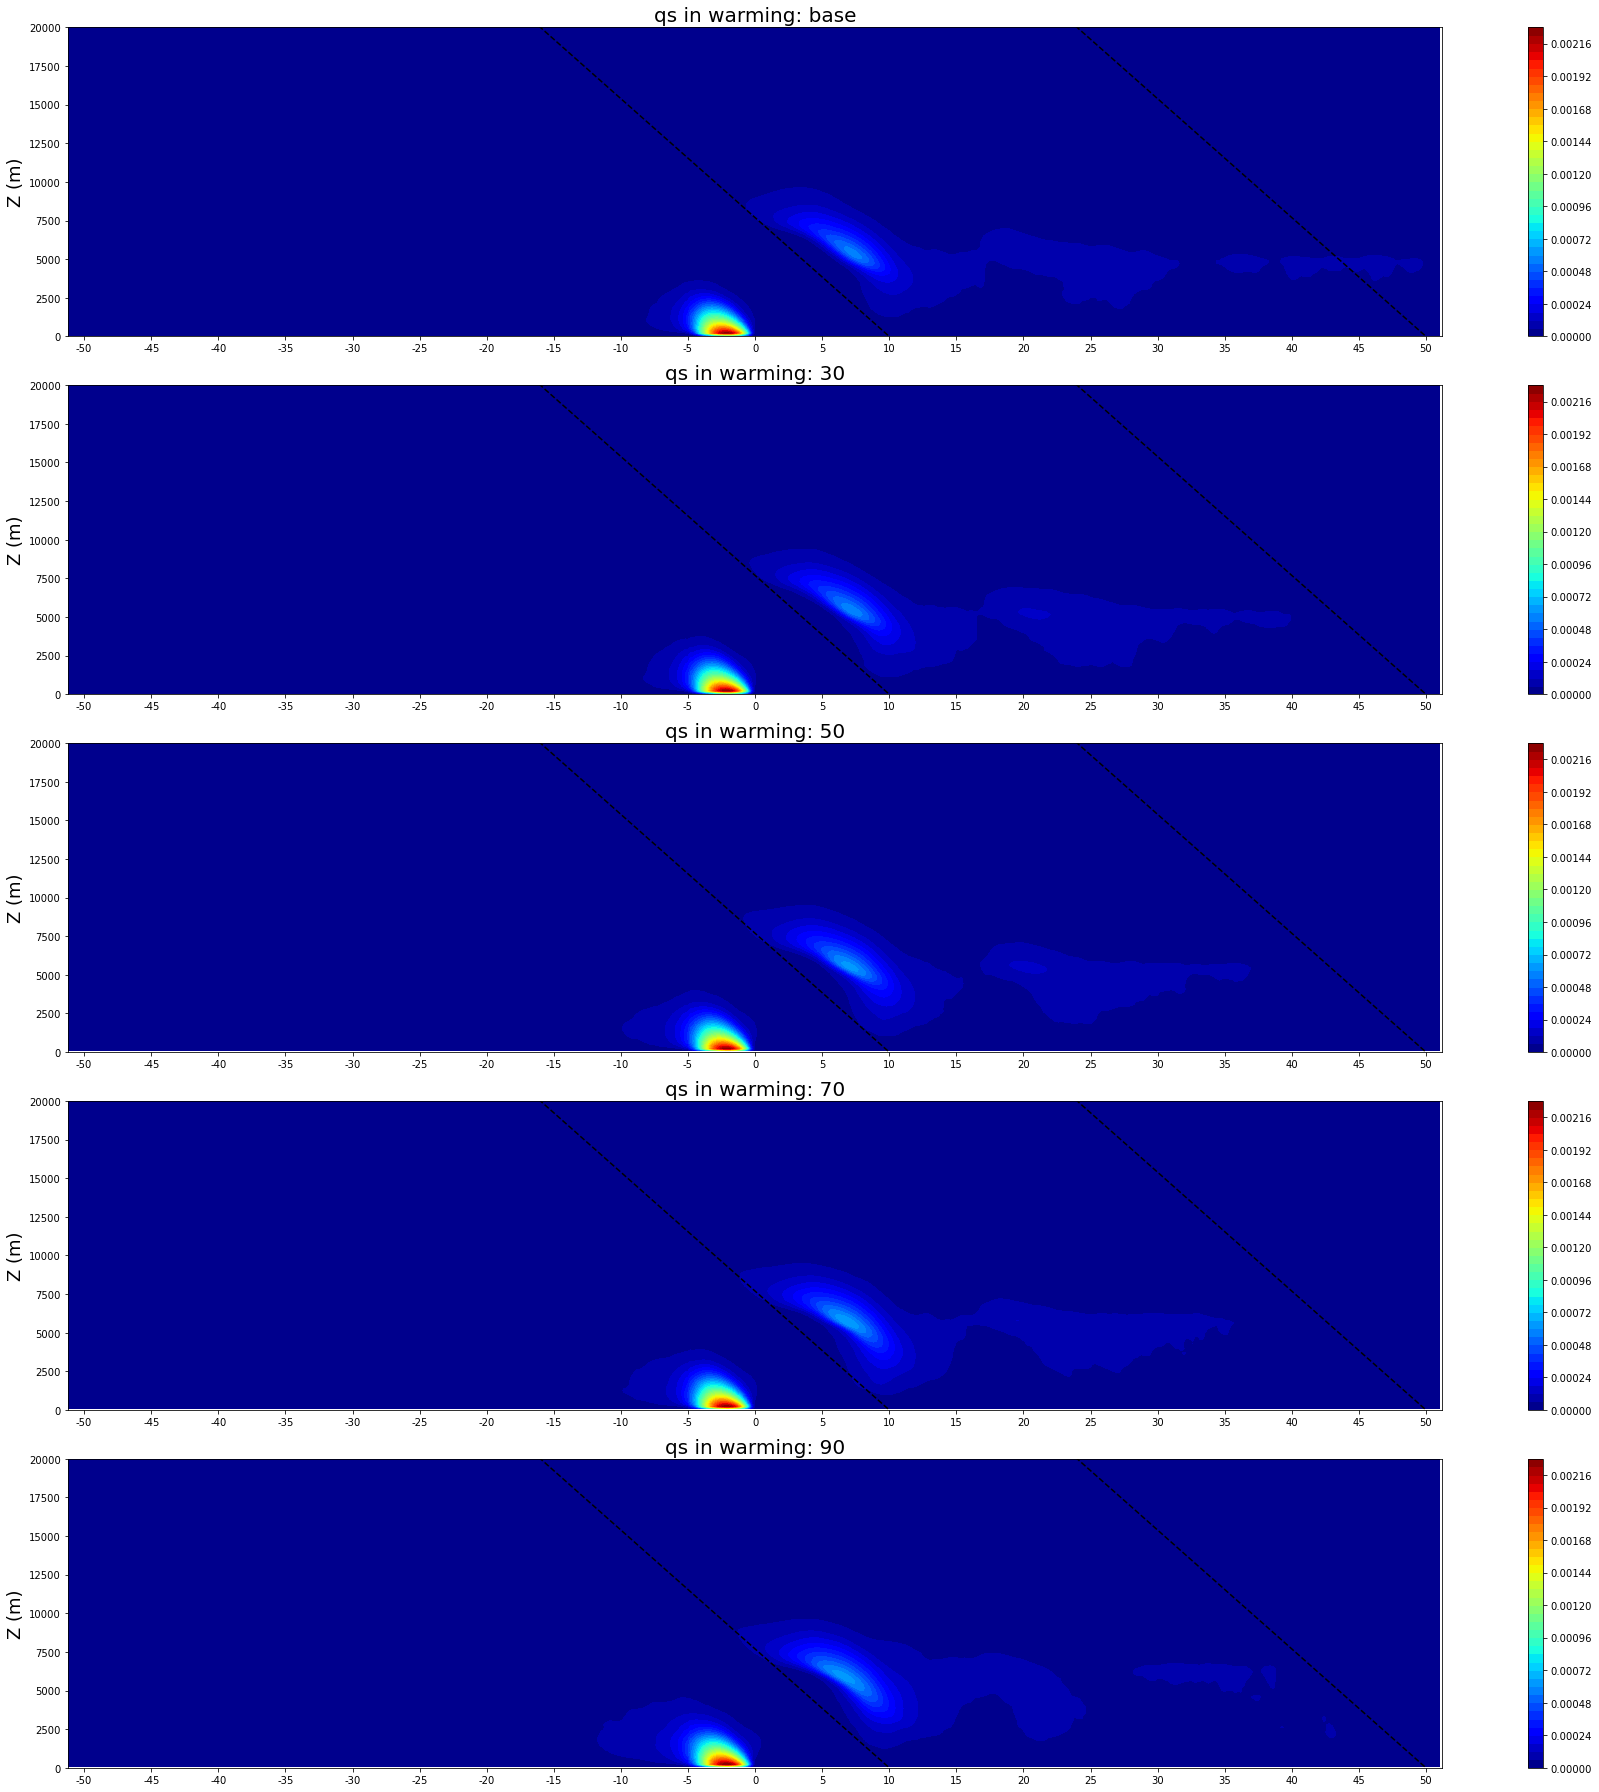

In [39]:
get_pe_3d( qt_cond_2d_w_list,qt_dep_2d_w_list,  qt_evar_2d_w_list, qt_evac_2d_w_list ,qt_subl_2d_w_list, zh, y_start=10, slope=-0.0013, y_end=50)

In [ ]:
fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(5,1,1)

ax2=fig.add_subplot(5,1,2)

ax3=fig.add_subplot(5,1,3)

ax4=fig.add_subplot(5,1,4)

ax5=fig.add_subplot(5,1,5)

for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax_1=ax.contourf(X,Y, qs_2d_list[sid,...]+  qg_2d_list[sid,...] +  qr_2d_list[sid,...] ,levels=np.linspace(0,1.8e-3,19))
    ax_2=ax.contour(X,Y, -qt_cond_2d_list[sid,...]-qt_dep_2d_list[sid,...],20,cmap='jet')

    fig.colorbar(ax_1,ax=ax)
    ax.set_ylim(0,20000)
    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
    #ax.set_title('qs in warming: ' + simu_list_name[sid], fontsize=20)
    ax.set_title('Qs+qg+qr not weighted and qt_cond+qt_dep not weighted  ' + simu_list_name[sid], fontsize=20)
    ax.set_ylabel('Z (m)',fontsize=18)
ax5.set_xlabel('Y (km)',fontsize=18)
plt.tight_layout()
fig.savefig(  pic_path+'no_weighted_cr_1' +'.png',dpi=200)

In [ ]:
fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(5,1,1)

ax2=fig.add_subplot(5,1,2)

ax3=fig.add_subplot(5,1,3)

ax4=fig.add_subplot(5,1,4)

ax5=fig.add_subplot(5,1,5)

for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax_1=ax.contourf(X,Y, qs_2d_list_w[sid,...]+  qg_2d_list_w[sid,...] +  qr_2d_list_w[sid,...] )
    ax_2=ax.contour(X,Y, -qt_cond_2d_w_list[sid,...]-qt_dep_2d_w_list[sid,...],40,cmap='jet')

    fig.colorbar(ax_1,ax=ax)
    ax.set_ylim(0,20000)
    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
    ax.set_title('Qs+qg+qr weighted and qt_cond+qt_dep weighted  ' + simu_list_name[sid], fontsize=20)
    ax.set_ylabel('Z (m)',fontsize=18)
ax5.set_xlabel('Y (km)',fontsize=18)



plt.tight_layout()

fig.savefig(  pic_path+'weighted_cr_1' +'.png',dpi=200)

In [ ]:
fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(5,1,1)

ax2=fig.add_subplot(5,1,2)

ax3=fig.add_subplot(5,1,3)

ax4=fig.add_subplot(5,1,4)

ax5=fig.add_subplot(5,1,5)

for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax_2=ax.contour(X,Y, qs_2d_list[sid,...]+  qg_2d_list[sid,...] +  qr_2d_list[sid,...] ,cmap='jet',levels=np.linspace(0,1.8e-3,19))
    ax_1=ax.contourf(X,Y, -qt_cond_2d_list[sid,...]-qt_dep_2d_list[sid,...],20)

    fig.colorbar(ax_1,ax=ax)
    ax.set_ylim(0,20000)
    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
    ax.set_title('qs in warming: ' + simu_list_name[sid], fontsize=20)
    ax.set_ylabel('Z (m)',fontsize=18)
ax5.set_xlabel('Y (km)',fontsize=18)
plt.tight_layout()

In [ ]:
fig=plt.figure(figsize=[25,25])

ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,2)
ax3=fig.add_subplot(5,1,3)
ax4=fig.add_subplot(5,1,4)
ax5=fig.add_subplot(5,1,5)

for sid in np.arange(5):

    ax1.plot(y,np.nansum(qs_2d_list_w[sid,...],axis=0),label=simu_list_name[sid])
    ax2.plot(y,np.nansum(qc_2d_list_w[sid,...],axis=0),label=simu_list_name[sid])
    ax3.plot(y,np.nansum(qi_2d_list_w[sid,...],axis=0),label=simu_list_name[sid])
    ax4.plot(y,np.nansum(qg_2d_list_w[sid,...],axis=0),label=simu_list_name[sid])
    ax5.plot(y,np.nansum(qr_2d_list_w[sid,...],axis=0),label=simu_list_name[sid])

ax1.set_title('qs' ,fontsize=20)
ax2.set_title('qc' ,fontsize=20)
ax3.set_title('qi' ,fontsize=20)
ax4.set_title('qg' ,fontsize=20)
ax5.set_title('qr' ,fontsize=20)
label_array=['(a)' ,'(b)' ,'(c)' ,'(d)' ,'(e)'  ]
for sid,ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax.text(-0.01, 1.1, label_array[sid], transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
    ax.legend()
ax5.set_xlabel('Y (km)',fontsize=18)

plt.tight_layout()
#fig.savefig(  pic_path+'qsci_cross' +'.png',dpi=200)

In [ ]:
fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(5,1,1)

ax2=fig.add_subplot(5,1,2)

ax3=fig.add_subplot(5,1,3)

ax4=fig.add_subplot(5,1,4)

ax5=fig.add_subplot(5,1,5)

for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax_1=ax.contourf(X,Y, qs_2d_list[sid,...],cmap='jet',levels=np.linspace(0,1.3e-3,14))

    fig.colorbar(ax_1,ax=ax)

    ax.set_ylim(0,20000)

    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)

    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))

    ax.set_title('qs in warming: ' + simu_list_name[sid], fontsize=20)

    ax.set_ylabel('Z (m)',fontsize=18)

ax5.set_xlabel('Y (km)',fontsize=18)

plt.tight_layout()

#fig.savefig(  pic_path+'qs' +'.png',dpi=200)

In [ ]:
fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,2)
ax3=fig.add_subplot(5,1,3)
ax4=fig.add_subplot(5,1,4)
ax5=fig.add_subplot(5,1,5)

for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax_1=ax.contourf(X,Y, qi_2d_list[sid,...],cmap='jet',levels=np.linspace(0,2e-4,21))
    fig.colorbar(ax_1,ax=ax)
    ax.set_ylim(0,20000)
    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
    ax.set_title('qi in warming: ' + simu_list_name[sid], fontsize=20)
    ax.set_ylabel('Z (m)',fontsize=18)
ax5.set_xlabel('Y (km)',fontsize=18)

plt.tight_layout()
#fig.savefig(  pic_path+'qi' +'.png',dpi=200)

In [ ]:
fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,2)
ax3=fig.add_subplot(5,1,3)
ax4=fig.add_subplot(5,1,4)
ax5=fig.add_subplot(5,1,5)

for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax_1=ax.contourf(X,Y, qc_2d_list[sid,...],cmap='jet',levels=np.linspace(0,2.5e-3,18))
    fig.colorbar(ax_1,ax=ax)
    ax.set_ylim(0,10000)
    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
    ax.set_title('qc in warming: ' + simu_list_name[sid], fontsize=20)
    ax.set_ylabel('Z (m)',fontsize=18)
ax5.set_xlabel('Y (km)',fontsize=18)

plt.tight_layout()
fig.savefig(  pic_path+'qc' +'.png',dpi=200)

In [ ]:
fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,2)
ax3=fig.add_subplot(5,1,3)
ax4=fig.add_subplot(5,1,4)
ax5=fig.add_subplot(5,1,5)

for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax_1=ax.contourf(X,Y, qg_2d_list[sid,...],cmap='jet')
    fig.colorbar(ax_1,ax=ax)
    ax.set_ylim(0,10000)
    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
    ax.set_title('qg in warming: ' + simu_list_name[sid], fontsize=20)
    ax.set_ylabel('Z (m)',fontsize=18)
ax5.set_xlabel('Y (km)',fontsize=18)

plt.tight_layout()
fig.savefig(  pic_path+'qg' +'.png',dpi=200)

In [ ]:
fig=plt.figure(figsize=[30,30])

ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,2)
ax3=fig.add_subplot(5,1,3)
ax4=fig.add_subplot(5,1,4)
ax5=fig.add_subplot(5,1,5)

for sid, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax_1=ax.contourf(X,Y, qr_2d_list[sid,...],cmap='jet')
    fig.colorbar(ax_1,ax=ax)
    ax.set_ylim(0,10000)
    ax.set_xticks(np.arange(-50000,50000+2,5000)/1000)
    ax.axes.xaxis.set_ticklabels( (np.arange(-50000,50000+2,5000)/1000).astype(int))
    ax.set_title('qr in warming: ' + simu_list_name[sid], fontsize=20)
    ax.set_ylabel('Z (m)',fontsize=18)
ax5.set_xlabel('Y (km)',fontsize=18)

plt.tight_layout()
fig.savefig(  pic_path+'qr' +'.png',dpi=200)